In [1]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader,TensorDataset
import matplotlib.pyplot as plt
import matplotlib
from torch.autograd import Variable

import torch.nn.functional as F
import numpy as np

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='../../data/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../../data/',
                                          train=False, 
                                          transform=transforms.ToTensor())

In [3]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=50, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=50, shuffle=False)

# Model

In [4]:
# Convolutional neural network (two convolutional layers)
class ConvNet_Base(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet_Base, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc1 = nn.Linear(7*7*32, 256)
        self.fc2 = nn.Linear(256, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        
        out = out.reshape(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.softmax(self.fc2(out))
        return out

In [5]:
# Convolutional neural network (two convolutional layers)
class ConvNet_Layer(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet_Layer, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc1 = nn.Linear(7*7*32, 256)
        self.fc2 = nn.Linear(256, num_classes)
        
    def forward(self, x, training_layer = 'fc2'):
        if training_layer == 'layer1':
            x = self.layer1(x)
          
        elif training_layer == 'layer2': 
            x = self.layer1(x)
            x = self.layer2(x)
            x = x.reshape(x.size(0), -1)
          
        elif training_layer == 'fc1':
            x = self.layer1(x)
            x = self.layer2(x)
            x = x.reshape(x.size(0), -1)
            x = torch.tanh(self.fc1(x))
          
        elif training_layer == 'fc2':
            x = self.layer1(x)
            x = self.layer2(x)
            x = x.reshape(x.size(0), -1)
            x = torch.tanh(self.fc1(x))
            x = F.softmax(self.fc2(x), dim=1)
      
        return x

# Evaluation

In [6]:
def plot_loss(layer1, epoche, loss_type):
    """
    plot the loss change during the training precedure
    """
    plt.title("Train "+ loss_type)
    plt.xlabel("epoch")
    plt.ylabel(loss_type)
    epoche_range=[i+1 for i in range(epoche)]
    plt.plot(epoche_range, layer1)
    #plt.plot(epoche_range, layer2)
    #plt.plot(epoche_range, fc)
    #plt.legend(['train loss', 'validation loss'], loc='best')
    plt.show()

def plot_acc(train, test, epoche):
    """
    plot the loss change during the training precedure
    """
    plt.title("Train and validation Accuarcy")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    epoche_range=[i+1 for i in range(epoche)]
    plt.plot(epoche_range, train)
    plt.plot(epoche_range, test)
    #plt.plot(epoche_range, fc)
    plt.legend(['train accuracy', 'test accuracy'], loc='best')
    plt.show()

def eval(model, isprint=True):
    model.eval()
    with torch.no_grad():
        train_correct = 0
        train_total = 0
        for images, labels in train_loader:
            images = images.float().to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
    
        train_acc = train_correct/train_total
    
    with torch.no_grad():
        test_correct = 0
        test_total = 0
        for images, labels in test_loader:
            images = images.float().to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    
        test_acc = test_correct/test_total

    if isprint:
        print('Accuracy of the network on the train: {} %'.format(100 * train_acc))
        print('Accuracy of the network on the test: {} %'.format(100 * test_acc))
    
    return train_acc, test_acc 

# Mine

In [7]:
import math

torch.autograd.set_detect_anomaly(True)

EPS = 1e-6

class EMALoss(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, running_ema):
        ctx.save_for_backward(input, running_ema)
        input_log_sum_exp = input.exp().mean().log()

        return input_log_sum_exp

    @staticmethod
    def backward(ctx, grad_output):
        input, running_mean = ctx.saved_tensors
        grad = grad_output * input.exp().detach() / \
            (running_mean + EPS) / input.shape[0]
        return grad, None


def ema(mu, alpha, past_ema):
    return alpha * mu + (1.0 - alpha) * past_ema


def ema_loss(x, running_mean, alpha):
    t_exp = torch.exp(torch.logsumexp(x, 0) - math.log(x.shape[0])).detach()
    if running_mean == 0:
        running_mean = t_exp
    else:
        running_mean = ema(t_exp, alpha, running_mean.item())
    t_log = EMALoss.apply(x, running_mean)

    # Recalculate ema

    return t_log, running_mean

class ConcatLayer(nn.Module):
    def __init__(self, dim=1):
        super().__init__()
        self.dim = dim

    def forward(self, x, y):
        x = x.view(x.shape[0], -1)
        y = y.view(y.shape[0], -1)
        return torch.cat((x, y), self.dim)


class CustomSequential(nn.Sequential):
    def forward(self, *input):
        for module in self._modules.values():
            if isinstance(input, tuple):
                input = module(*input)
            else:
                input = module(input)
        return input

class T(nn.Module):
    def __init__(self, x_dim, z_dim):
        super().__init__()
        self.layers = CustomSequential(ConcatLayer(), nn.Linear(x_dim + z_dim, 400),
                                       nn.ReLU(),
                                       nn.Linear(400, 400),
                                       nn.ReLU(),
                                       nn.Linear(400, 400),
                                       nn.ReLU(),
                                       nn.Linear(400, 1))

    def forward(self, x, z):
        return self.layers(x, z)

class Mine(nn.Module):
    def __init__(self, T, loss='mine', alpha=0.01, method=None):
        super().__init__()
        self.running_mean = 0
        self.loss = loss
        self.alpha = alpha
        self.method = method

        if method == 'concat':
            if isinstance(T, nn.Sequential):
                self.T = CustomSequential(ConcatLayer(), *T)
            else:
                self.T = CustomSequential(ConcatLayer(), T)
        else:
            self.T = T

    def forward(self, x, z, z_marg=None):
        if z_marg is None:
            z_marg = z[torch.randperm(x.shape[0])]

        t = self.T(x, z).mean()
        t_marg = self.T(x, z_marg)

        if self.loss in ['mine']:
            second_term, self.running_mean = ema_loss(
                t_marg, self.running_mean, self.alpha)
        elif self.loss in ['fdiv']:
            second_term = torch.exp(t_marg - 1).mean()
        elif self.loss in ['mine_biased']:
            second_term = torch.logsumexp(
                t_marg, 0) - math.log(t_marg.shape[0])

        return -t + second_term
    
class ConvolutionalStatisticsNetwork(nn.Module):
    def __init__(self, num_x_channel, z_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(num_x_channel, 16, kernel_size=5,
                               stride=2, padding=2, bias=False)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5,
                               stride=2, padding=2, bias=False)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5,
                               stride=2, padding=2, bias=False)

        self.fc1 = nn.Linear(4 * 4 * 64, 1)

        self.z_linear1 = nn.Linear(z_dim, 16)
        self.z_linear2 = nn.Linear(z_dim, 32)
        self.z_linear3 = nn.Linear(z_dim, 64)

    def xz_block(self, x, z, x_layer, z_layer):
        x_out = x_layer(x)
        z_map = z_layer(z).unsqueeze(-1).unsqueeze(-1).expand_as(x_out)
        #print(x_out.shape, z_map.shape)
        return F.elu(x_out + z_map)

    def forward(self, x, z):
        z = z.view(z.shape[0], -1)
        x = self.xz_block(x, z, self.conv1, self.z_linear1)
        x = self.xz_block(x, z, self.conv2, self.z_linear2)
        x = self.xz_block(x, z, self.conv3, self.z_linear3)

        x = x.view(x.size(0), -1)
        return self.fc1(x)

# DIM

In [8]:
class GlobalVector(torch.nn.Module):
    def __init__(self, in_channel, num_feature=64, out_size=64, input_shape=(32,32)):
        super().__init__()

        assert isinstance(input_shape, tuple), "tuple of integers."
        self.input_shape = input_shape
        #self.M_shape = (input_shape[0]-3*2, input_shape[1]-3*2)
        #self.M_channels = num_feature*2

        self.c0 = torch.nn.Conv2d(in_channel, num_feature, kernel_size=4, stride=1)
        self.c1 = torch.nn.Conv2d(num_feature, num_feature*2, kernel_size=4, stride=1)
        self.c2 = torch.nn.Conv2d(num_feature*2, num_feature*4, kernel_size=4, stride=1)
        self.c3 = torch.nn.Conv2d(num_feature*4, num_feature*8, kernel_size=4, stride=1)

        in_feature = num_feature*8 * (input_shape[0]-3*4) * (input_shape[1]-3*4)
        self.l1 = torch.nn.Linear(in_feature, out_size)
        self.l2 = torch.nn.Linear(128, out_size)
        self.b1 = torch.nn.BatchNorm2d(num_feature*2)
        self.b2 = torch.nn.BatchNorm2d(num_feature*4)
        self.b3 = torch.nn.BatchNorm2d(num_feature*8)

    def forward(self, x):

        E = F.relu(self.c0(x))
        E = F.relu(self.b1(self.c1(E)))
            
        if E.shape[-1] <= 4:
            return self.l2(E.view(x.shape[0], -1))
        else:   
            E = F.relu(self.b2(self.c2(E)))   
            E = F.relu(self.b3(self.c3(E)))
            E = self.l1(E.view(x.shape[0], -1))
            return E

        # see appendix 1A of https://arxiv.org/pdf/1808.06670.pdf
        # E is the encoded E_{phi}(x)
        # M is the M x M feature maps
        #return E, M
        return E

class GlobalDiscriminator(torch.nn.Module):
    """
    input of GlobalDiscriminator is the `M` in Encoder.forward, so with
    channels : num_feature * 2, in_channels
    shape    : (input_shape[0]-3*2, input_shape[1]-3*2), M_shape
    """
    def __init__(self, M_channels, M_shape, E_size, interm_size=512):
        super().__init__()

        in_channels = M_channels; out_channels = in_channels // 2
        self.c0 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=3)
        in_channels = out_channels; out_channels = in_channels // 2
        self.c1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=3)

        # see appendix 1A of https://arxiv.org/pdf/1808.06670.pdf
        # input of self.l0 is the concatenate of E and flattened output of self.c1 (C)
        in_feature = out_channels * (M_shape[0]-2*2) * (M_shape[1]-2*2) + E_size
        self.l0 = torch.nn.Linear(in_feature, interm_size)
        self.l1 = torch.nn.Linear(interm_size, interm_size)
        self.l2 = torch.nn.Linear(interm_size, 1)

    def forward(self, E, M):

        C = F.relu(self.c0(M))
        C = self.c1(C)
        C = C.view(E.shape[0], -1)
        out = torch.cat((E, C), dim=1)
        out = F.relu(self.l0(out))
        out = F.relu(self.l1(out))
        out = self.l2(out)

        # see appendix 1A of https://arxiv.org/pdf/1808.06670.pdf
        # output of Table 5
        return out


class LocalDiscriminator(torch.nn.Module):
    """
    the local discriminator with architecture described in
    Figure 4 and Table 6 in appendix 1A of https://arxiv.org/pdf/1808.06670.pdf.
    input is the concatenate of
    "replicated feature vector E (with M_shape now)" + "M"
    replicated means that all pixels are the same, they are just copies.
    """
    def __init__(self, M_channels, E_size, interm_channels=512):
        super().__init__()

        in_channels = E_size + M_channels
        self.c0 = torch.nn.Conv2d(in_channels, interm_channels, kernel_size=1)
        self.c1 = torch.nn.Conv2d(interm_channels, interm_channels, kernel_size=1)
        self.c2 = torch.nn.Conv2d(interm_channels, 1, kernel_size=1)

    def forward(self, x):

        score = F.relu(self.c0(x))
        score = F.relu(self.c1(score))
        score = self.c2(score)

        return score

class PriorDiscriminator(torch.nn.Module):
    """
    the Prior discriminator with architecture described in
    Figure 6 and Table 9 in appendix 1A of https://arxiv.org/pdf/1808.06670.pdf.
    input will be Real feature vector E and Fake feature vector E_fake (E_like shape),
    This discriminator is trained to distinguish Real and Fake inputs.
    So the Encoder is trained to "fool" this discriminator. (idea of GAN)
    """
    def __init__(self, E_size, interm_size=(1000,200)):
        super().__init__()
        assert isinstance(interm_size, tuple), "tuple of integers."

        self.l0 = torch.nn.Linear(E_size, interm_size[0])
        self.l1 = torch.nn.Linear(interm_size[0], interm_size[1])
        self.l2 = torch.nn.Linear(interm_size[1], 1)

    def forward(self, x):

        score = F.relu(self.l0(x))
        score = F.relu(self.l1(score))
        score = torch.sigmoid(self.l2(score))

        return score

class DeepInfoMaxLoss(torch.nn.Module):

    def __init__(self, in_channel, M_channels, M_shape, out_size, input_shape=(32,32), alpha=0.5, beta=1.0, gamma=0.1, num_feature=64, interm_size_G=512, interm_channels_L=512, interm_size_P=(1000,200)):
        super().__init__()

        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.M_channels = M_channels
        self.M_shape = M_shape
        self.get_models(in_channel=in_channel,
                        M_channels = M_channels,
                        M_shape = M_shape,
                        out_size = out_size,
                        input_shape=input_shape, 
                        num_feature=num_feature, 
                        interm_size_G=interm_size_G, 
                        interm_channels_L=interm_channels_L, 
                        interm_size_P=interm_size_P)

    def get_models(self, in_channel, M_channels, M_shape, out_size, input_shape=(32,32), num_feature=64, interm_size_G=512, interm_channels_L=512, interm_size_P=(1000,200) ):

        self.encoder = GlobalVector(in_channel=in_channel, input_shape=input_shape, num_feature=num_feature, out_size=out_size)
        self.global_D = GlobalDiscriminator(M_channels=M_channels, M_shape=M_shape, E_size=out_size, interm_size=interm_size_G)
        self.local_D = LocalDiscriminator(M_channels=M_channels, E_size=out_size, interm_channels=interm_channels_L)
        self.prior_D = PriorDiscriminator(E_size=out_size, interm_size=interm_size_P)

    def forward(self, Y, M, M_fake):
        # see appendix 1A of https://arxiv.org/pdf/1808.06670.pdf
        
        Y_replicated = Y.unsqueeze(-1).unsqueeze(-1)
        Y_replicated = Y_replicated.expand(-1, -1, self.M_shape[0], self.M_shape[1])

        Y_cat_M = torch.cat((M, Y_replicated), dim=1)
        Y_cat_M_fake = torch.cat((M_fake, Y_replicated), dim=1)

        # local loss
        # 2nd term in equation (8) in https://arxiv.org/pdf/1808.06670.pdf
        Ej = -F.softplus(-self.local_D(Y_cat_M)).mean()
        Em = -F.softplus(-self.local_D(Y_cat_M_fake)).mean()
        local_loss = (Em - Ej) * self.beta

        # global loss
        # 1st term in equation (8) in https://arxiv.org/pdf/1808.06670.pdf
        Ej = -F.softplus(-self.global_D(Y, M)).mean()
        Em = -F.softplus(-self.global_D(Y, M_fake)).mean()
        global_loss= (Em - Ej) * self.alpha

        # prior loss
        # 3rd term in equation (8) in https://arxiv.org/pdf/1808.06670.pdf
        prior = torch.rand_like(Y)
        # 1st term in equation (7) in https://arxiv.org/pdf/1808.06670.pdf
        term_a = torch.log(self.prior_D(prior)).mean()
        # 2nd term in equation (7) in https://arxiv.org/pdf/1808.06670.pdf
        term_b = torch.log(1 - self.prior_D(Y)).mean()
        prior_loss = - (term_a + term_b) * self.gamma

        return local_loss + global_loss + prior_loss

# Train

In [9]:
def training_block(num_epochs, model, training_layer, mine, loss_type, optimizer, train_loader, iseval = False):
    result_list = []
    total_step = len(train_loader)
    train_acc_list = []
    test_acc_list = []
    #if loss_type != "cross entropy":
        #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
    for epoch in range(num_epochs):

        model.train()  # set the model to training mode
        if loss_type != "cross entropy":
            mine.train()
        sum_MI = 0
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
      
            # Forward pass
            outputs = model(images, training_layer=training_layer)
            if loss_type == '-MI(X;Z) layer1':
                Y = mine.encoder(outputs)
                M_fake = torch.cat((outputs[1:], outputs[0].unsqueeze(0)), dim=0)
                loss = mine(Y, outputs, M_fake).to(device)
            elif loss_type == '-MI(X;Z) layer2':
                #labels = labels.view(labels.shape[0], -1).to(device) 
                loss = mine(images, outputs).to(device)    
            elif loss_type == '-MI(Y;Z)':
                #labels = labels.view(labels.shape[0], -1).to(device) 
                loss = mine(labels, outputs).to(device)
                
                
            elif loss_type == "cross entropy":
                #labels = labels.view(labels.shape[0], -1).to(device) 
                loss = mine(outputs, labels).to(device)
      
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            #if loss_type != "cross entropy":
                #scheduler.step()
        MI = loss.item()
        sum_MI += MI
   
        avg_MI = sum_MI/total_step
        result_list.append(avg_MI)
        output = 'Epoch [{}/{}], '+ training_layer+' ' + loss_type +' : {:.12f}' 
        print (output.format(epoch+1, num_epochs, avg_MI))
        if iseval:
            if epoch == num_epochs-1:
                isprint = True
            else:
                isprint = False
            train_acc, test_acc = eval(model, isprint=isprint)
            train_acc_list.append(train_acc)
            test_acc_list.append(test_acc)
    if len(train_acc_list) == num_epochs: 
        plot_acc(train_acc_list, test_acc_list, num_epochs)
  
    if iseval:
        return result_list, train_acc_list[-1], test_acc_list[-1]
    else:
        return result_list

# Modular Training

In [10]:
def Modular_training(model, num_epochs, estimator, loss_list, layer_list, train_dataset):
    if len(train_dataset) < 1000:
        train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=len(train_dataset), shuffle=True)
    else:
        train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=1000, shuffle=True)
  
    for param in model.parameters(): 
        param.requires_grad = False
  
    #training layer1
    print("Training layer1")
    for name, param in model.layer1.named_parameters():
        param.requires_grad = True
    loss_type = loss_list[0]
    training_layer = layer_list[0]
    mine = estimator[0].to(device)
    optimizer = torch.optim.Adam(
                                [{"params": model.parameters(), "lr": 1e-5},
                                {"params": mine.parameters(), "lr": 1e-5}])
    layer1 = training_block(num_epochs, model, training_layer, mine, loss_type, optimizer, train_loader)
    for name, param in model.layer1.named_parameters():
        param.requires_grad = False

    #training layer2
    print("Training layer2")
    for name, param in model.layer2.named_parameters():
        param.requires_grad = True
    loss_type = loss_list[1]
    training_layer = layer_list[1]
    mine = estimator[1].to(device)
    optimizer = torch.optim.Adam(
                                [{"params": model.parameters(), "lr": 1e-5},
                                {"params": mine.parameters(), "lr": 1e-5}])
    layer2 = training_block(num_epochs, model, training_layer, mine, loss_type, optimizer, train_loader)
    for name, param in model.layer2.named_parameters():
        param.requires_grad = False

    #training fc1
    print("Training fc1")
    for name, param in model.fc1.named_parameters():
        param.requires_grad = True
    loss_type = loss_list[2]
    training_layer = layer_list[2]
    mine = Mine(estimator[2]).to(device)
    optimizer = torch.optim.Adam(
                                [{"params": model.parameters(), "lr": 1e-5},
                                {"params": mine.parameters(), "lr": 1e-5}])
    fc1 = training_block(num_epochs, model, training_layer, mine, loss_type, optimizer, train_loader)
    for name, param in model.fc1.named_parameters():
        param.requires_grad = False

    #training fc2
    print("Training fc2")
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=50, shuffle=True)
    for name, param in model.fc2.named_parameters():
        param.requires_grad = True
    loss_type = loss_list[3]
    training_layer = layer_list[3]
    mine = nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    fc2, train_acc, test_acc = training_block(num_epochs, model, training_layer, mine, loss_type, optimizer, train_loader, iseval=True)
    for name, param in model.fc2.named_parameters():
        param.requires_grad = False
    return layer1, layer2, fc1, fc2, train_acc, test_acc

In [11]:
model = ConvNet_Layer().to(device)
T_estimator = [DeepInfoMaxLoss(in_channel=16, M_channels=16, M_shape=(14,14), out_size=16, input_shape=(14,14)), 
               DeepInfoMaxLoss(in_channel=32, M_channels=32, M_shape=(7,7), out_size=32, input_shape=(7,7)),
               T(1, 256)]

In [ ]:
model_save_name = 'DIMonMNIST.pt'
path = F"./model/{model_save_name}" 
model = torch.load(path)                 
model_save_name = 'DIMonMNISTlayer1.pt'
path = F"./model/{model_save_name}" 
T_estimator1 = torch.load(path)
model_save_name = 'DIMonMNISTlayer2.pt'
path = F"./model/{model_save_name}" 
T_estimator2 = torch.load(path)
model_save_name = 'DIMonMNISTlayer3.pt'
path = F"./model/{model_save_name}" 
T_estimator3 = torch.load(path)
T_estimator = [T_estimator1, T_estimator2, T_estimator3]  
train_acc, test_acc = eval(model, isprint=True)

In [13]:
loss_list = ['-MI(X;Z)', '-MI(X;Z)', "-MI(Y;Z)", "cross entropy"]
layer_list = ["layer1", "layer2", 'fc1', 'fc2']
num_epochs = 1
layer1, layer2, fc1, fc2, _, _ = Modular_training(model, num_epochs, T_estimator, loss_list, layer_list, train_dataset)

Training layer1


RuntimeError: CUDA out of memory. Tried to allocate 48.00 MiB (GPU 0; 23.69 GiB total capacity; 1.53 GiB already allocated; 12.94 MiB free; 1.59 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
plot_loss(layer1, num_epochs, loss_list[0])
plot_loss(layer2, num_epochs, loss_list[1])
plot_loss(fc1, num_epochs, loss_list[2])
plot_loss(fc2, num_epochs, loss_list[3])

# Model and Estimators Initialization

In [10]:
model = ConvNet_Layer().to(device)
T_estimator = [DeepInfoMaxLoss(in_channel=16, M_channels=16, M_shape=(14,14), out_size=16, input_shape=(14,14)), 
               Mine(ConvolutionalStatisticsNetwork(1, 32*7*7)),
               Mine(T(1, 256))]


# Training layer1

In [49]:
model_save_name = 'DIMonMNIST.pt'
path = F"./model/{model_save_name}" 
model = torch.load(path)                 
model_save_name = 'DIMonMNISTlayer1.pt'
path = F"./model/{model_save_name}" 
T_estimator1 = torch.load(path)
model_save_name = 'DIMonMNISTlayer2.pt'
path = F"./model/{model_save_name}" 
T_estimator2 = torch.load(path)
model_save_name = 'DIMonMNISTlayer3.pt'
path = F"./model/{model_save_name}" 
T_estimator3 = torch.load(path)
T_estimator = [T_estimator1, T_estimator2, T_estimator3]  
train_acc, test_acc = eval(model, isprint=True)

Accuracy of the network on the train: 10.095 %
Accuracy of the network on the test: 9.75 %


Training layer1
Epoch [1/100], layer1 -MI(X;Z) layer1 : -3360641061137.066894531250
Epoch [2/100], layer1 -MI(X;Z) layer1 : -3279246397713.066894531250
Epoch [3/100], layer1 -MI(X;Z) layer1 : -3455352919381.333496093750
Epoch [4/100], layer1 -MI(X;Z) layer1 : -3587885096413.866699218750
Epoch [5/100], layer1 -MI(X;Z) layer1 : -3628904271052.799804687500
Epoch [6/100], layer1 -MI(X;Z) layer1 : -3724568515925.333496093750
Epoch [7/100], layer1 -MI(X;Z) layer1 : -3574223968665.600097656250
Epoch [8/100], layer1 -MI(X;Z) layer1 : -3869200980377.600097656250
Epoch [9/100], layer1 -MI(X;Z) layer1 : -4048659310182.399902343750
Epoch [10/100], layer1 -MI(X;Z) layer1 : -4064569703355.733398437500
Epoch [11/100], layer1 -MI(X;Z) layer1 : -4177007529164.799804687500
Epoch [12/100], layer1 -MI(X;Z) layer1 : -4190532481843.200195312500
Epoch [13/100], layer1 -MI(X;Z) layer1 : -4415081257369.599609375000
Epoch [14/100], layer1 -MI(X;Z) layer1 : -4580680488277.333007812500
Epoch [15/100], layer1 -MI(

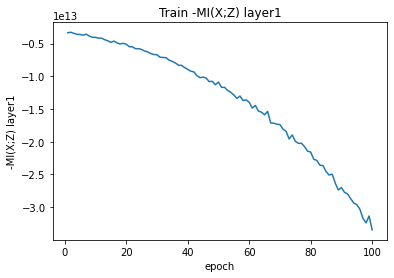

In [50]:
loss_list = ['-MI(X;Z) layer1', '-MI(X;Z) layer2', "-MI(Y;Z)", "cross entropy"]
layer_list = ["layer1", "layer2", 'fc1', 'fc2']
num_epochs = 100
if len(train_dataset) < 1000:
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=len(train_dataset), shuffle=True)
else:
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=1000, shuffle=True)
  
for param in model.parameters(): 
    param.requires_grad = False
  
#training layer1
print("Training layer1")
for name, param in model.layer1.named_parameters():
    param.requires_grad = True
loss_type = loss_list[0]
training_layer = layer_list[0]
mine = T_estimator[0].to(device)
optimizer = torch.optim.Adam(
                                [{"params": model.parameters(), "lr": 1e-5},
                                {"params": mine.parameters(), "lr": 1e-3}])
layer1 = training_block(num_epochs, model, training_layer, mine, loss_type, optimizer, train_loader)
for name, param in model.layer1.named_parameters():
    param.requires_grad = False
plot_loss(layer1, num_epochs, loss_list[0])

In [51]:
model_save_name = 'DIMonMNIST.pt'
path = F"./model/{model_save_name}"
torch.save(model, path)
model_save_name = 'DIMonMNISTlayer1.pt'
path = F"./model/{model_save_name}" 
torch.save(T_estimator[0], path)
model_save_name = 'DIMonMNISTlayer2.pt'
path = F"./model/{model_save_name}" 
torch.save(T_estimator[1], path)
model_save_name = 'DIMonMNISTlayer3.pt'
path = F"./model/{model_save_name}" 
torch.save(T_estimator[2], path)
train_acc, test_acc = eval(model, isprint=True)

Accuracy of the network on the train: 10.075000000000001 %
Accuracy of the network on the test: 9.65 %


# Training layer2

In [67]:
model_save_name = 'DIMonMNIST.pt'
path = F"./model/{model_save_name}" 
model = torch.load(path)                 
model_save_name = 'DIMonMNISTlayer1.pt'
path = F"./model/{model_save_name}" 
T_estimator1 = torch.load(path)
model_save_name = 'DIMonMNISTlayer2.pt'
path = F"./model/{model_save_name}" 
T_estimator2 = torch.load(path)
model_save_name = 'DIMonMNISTlayer3.pt'
path = F"./model/{model_save_name}" 
T_estimator3 = torch.load(path)
T_estimator = [T_estimator1, T_estimator2, T_estimator3]  
train_acc, test_acc = eval(model, isprint=True)

Accuracy of the network on the train: 6.808333333333333 %
Accuracy of the network on the test: 6.959999999999999 %


Training layer2
Epoch [1/1], layer2 -MI(X;Z) layer2 : -0.104301778475


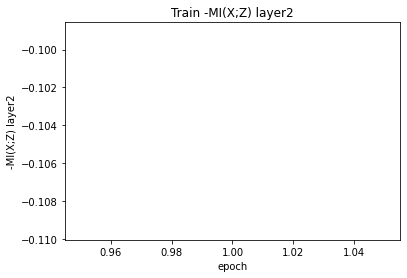

In [68]:
loss_list = ['-MI(X;Z) layer1', '-MI(X;Z) layer2', "-MI(Y;Z)", "cross entropy"]
layer_list = ["layer1", "layer2", 'fc1', 'fc2']
num_epochs = 1

if len(train_dataset) < 1000:
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=len(train_dataset), shuffle=True)
else:
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=1000, shuffle=True)
  
for param in model.parameters(): 
    param.requires_grad = False

#training layer2
print("Training layer2")
for name, param in model.layer2.named_parameters():
    param.requires_grad = True
loss_type = loss_list[1]
training_layer = layer_list[1]
mine = T_estimator[1].to(device)
optimizer = torch.optim.Adam(
                                [{"params": model.parameters(), "lr": 1e-5},
                                {"params": mine.parameters(), "lr": 1e-6}])
layer2 = training_block(num_epochs, model, training_layer, mine, loss_type, optimizer, train_loader)
for name, param in model.layer2.named_parameters():
    param.requires_grad = False
plot_loss(layer2, num_epochs, loss_list[1])

In [69]:
model_save_name = 'DIMonMNIST.pt'
path = F"./model/{model_save_name}"
torch.save(model, path)
model_save_name = 'DIMonMNISTlayer1.pt'
path = F"./model/{model_save_name}" 
torch.save(T_estimator[0], path)
model_save_name = 'DIMonMNISTlayer2.pt'
path = F"./model/{model_save_name}" 
torch.save(T_estimator[1], path)
model_save_name = 'DIMonMNISTlayer3.pt'
path = F"./model/{model_save_name}" 
torch.save(T_estimator[2], path)
train_acc, test_acc = eval(model, isprint=True)

Accuracy of the network on the train: 6.821666666666666 %
Accuracy of the network on the test: 6.94 %


# Training fc1

In [142]:
model_save_name = 'DIMonMNIST.pt'
path = F"./model/{model_save_name}" 
model = torch.load(path)                 
model_save_name = 'DIMonMNISTlayer1.pt'
path = F"./model/{model_save_name}" 
T_estimator1 = torch.load(path)
model_save_name = 'DIMonMNISTlayer2.pt'
path = F"./model/{model_save_name}" 
T_estimator2 = torch.load(path)
model_save_name = 'DIMonMNISTlayer3.pt'
path = F"./model/{model_save_name}" 
T_estimator3 = torch.load(path)
T_estimator = [T_estimator1, T_estimator2, T_estimator3]  
train_acc, test_acc = eval(model, isprint=True)

Accuracy of the network on the train: 10.718333333333334 %
Accuracy of the network on the test: 10.69 %


Training fc1
Epoch [1/1], fc1 -MI(Y;Z) : -0.041257286072


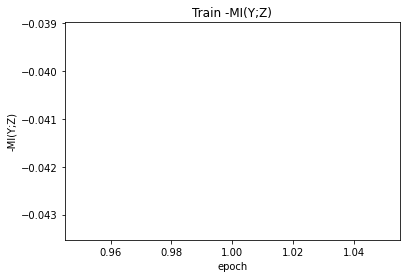

In [143]:
loss_list = ['-MI(X;Z) layer1', '-MI(X;Z) layer2', "-MI(Y;Z)", "cross entropy"]
layer_list = ["layer1", "layer2", 'fc1', 'fc2']
num_epochs = 1

if len(train_dataset) < 1000:
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=len(train_dataset), shuffle=True)
else:
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=1000, shuffle=True)
     
for param in model.parameters(): 
    param.requires_grad = False
  
#training fc1
print("Training fc1")
for name, param in model.fc1.named_parameters():
    param.requires_grad = True
loss_type = loss_list[2]
training_layer = layer_list[2]
mine = T_estimator[2].to(device)
optimizer = torch.optim.Adam(
                                [{"params": model.parameters(), "lr": 1e-5},
                                {"params": mine.parameters(), "lr": 1e-7}])
fc1 = training_block(num_epochs, model.to(device), training_layer, mine.to(device), loss_type, optimizer, train_loader)
for name, param in model.fc1.named_parameters():
    param.requires_grad = False
plot_loss(fc1, num_epochs, loss_list[2])

In [144]:
model_save_name = 'DIMonMNIST.pt'
path = F"./model/{model_save_name}"
torch.save(model, path)
model_save_name = 'DIMonMNISTlayer1.pt'
path = F"./model/{model_save_name}" 
torch.save(T_estimator[0], path)
model_save_name = 'DIMonMNISTlayer2.pt'
path = F"./model/{model_save_name}" 
torch.save(T_estimator[1], path)
model_save_name = 'DIMonMNISTlayer3.pt'
path = F"./model/{model_save_name}" 
torch.save(T_estimator[2], path)
train_acc, test_acc = eval(model, isprint=True)

Accuracy of the network on the train: 10.791666666666666 %
Accuracy of the network on the test: 10.8 %


# Training fc2

In [152]:
model_save_name = 'DIMonMNIST.pt'
path = F"./model/{model_save_name}" 
model = torch.load(path)                 
model_save_name = 'DIMonMNISTlayer1.pt'
path = F"./model/{model_save_name}" 
T_estimator1 = torch.load(path)
model_save_name = 'DIMonMNISTlayer2.pt'
path = F"./model/{model_save_name}" 
T_estimator2 = torch.load(path)
model_save_name = 'DIMonMNISTlayer3.pt'
path = F"./model/{model_save_name}" 
T_estimator3 = torch.load(path)
T_estimator = [T_estimator1, T_estimator2, T_estimator3]  
train_acc, test_acc = eval(model, isprint=True)

Accuracy of the network on the train: 98.6 %
Accuracy of the network on the test: 96.85000000000001 %


Training fc2
Epoch [1/100], fc2 cross entropy : 0.001229825417
Epoch [2/100], fc2 cross entropy : 0.001252348026
Epoch [3/100], fc2 cross entropy : 0.001224633058
Epoch [4/100], fc2 cross entropy : 0.001239073177
Epoch [5/100], fc2 cross entropy : 0.001221068700
Epoch [6/100], fc2 cross entropy : 0.001237031519
Epoch [7/100], fc2 cross entropy : 0.001227441132
Epoch [8/100], fc2 cross entropy : 0.001253588696
Epoch [9/100], fc2 cross entropy : 0.001238707701
Epoch [10/100], fc2 cross entropy : 0.001230558157
Epoch [11/100], fc2 cross entropy : 0.001231473684
Epoch [12/100], fc2 cross entropy : 0.001280355950
Epoch [13/100], fc2 cross entropy : 0.001233926018
Epoch [14/100], fc2 cross entropy : 0.001229007939
Epoch [15/100], fc2 cross entropy : 0.001235094865
Epoch [16/100], fc2 cross entropy : 0.001249123514
Epoch [17/100], fc2 cross entropy : 0.001234319210
Epoch [18/100], fc2 cross entropy : 0.001237989664
Epoch [19/100], fc2 cross entropy : 0.001238789856
Epoch [20/100], fc2 cross e

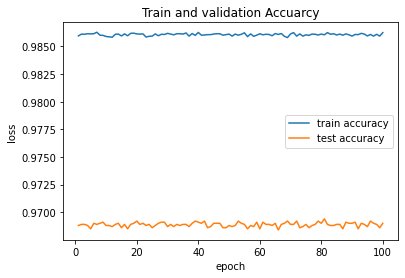

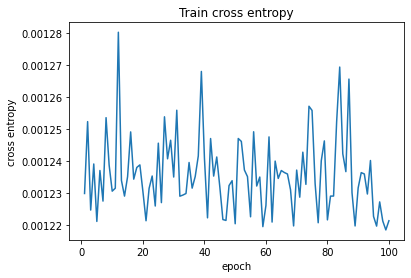

In [153]:
loss_list = ['-MI(X;Z) layer1', '-MI(X;Z) layer2', "-MI(Y;Z)", "cross entropy"]
layer_list = ["layer1", "layer2", 'fc1', 'fc2']
num_epochs = 100

for param in model.parameters(): 
    param.requires_grad = False
#training fc2
print("Training fc2")
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=50, shuffle=True)
for name, param in model.fc2.named_parameters():
    param.requires_grad = True
loss_type = loss_list[3]
training_layer = layer_list[3]
mine = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0000001)
fc2, train_acc, test_acc = training_block(num_epochs, model.to(device), training_layer, mine, loss_type, optimizer, train_loader, iseval=True)
for name, param in model.fc2.named_parameters():
    param.requires_grad = False
plot_loss(fc2, num_epochs, loss_list[3])

In [154]:
model_save_name = 'DIMonMNIST.pt'
path = F"./model/{model_save_name}"
torch.save(model, path)
model_save_name = 'DIMonMNISTlayer1.pt'
path = F"./model/{model_save_name}" 
torch.save(T_estimator[0], path)
model_save_name = 'DIMonMNISTlayer2.pt'
path = F"./model/{model_save_name}" 
torch.save(T_estimator[1], path)
model_save_name = 'DIMonMNISTlayer3.pt'
path = F"./model/{model_save_name}" 
torch.save(T_estimator[2], path)
train_acc, test_acc = eval(model, isprint=True)

Accuracy of the network on the train: 98.625 %
Accuracy of the network on the test: 96.89999999999999 %


# Save Model

In [ ]:
model_save_name = 'DIMonMNIST.pt'
path = F"./model/{model_save_name}"
torch.save(model, path)
model_save_name = 'DIMonMNISTlayer1.pt'
path = F"./model/{model_save_name}" 
torch.save(T_estimator[0], path)
model_save_name = 'DIMonMNISTlayer2.pt'
path = F"./model/{model_save_name}" 
torch.save(T_estimator[1], path)
model_save_name = 'DIMonMNISTlayer3.pt'
path = F"./model/{model_save_name}" 
torch.save(T_estimator[2], path)
train_acc, test_acc = eval(model, isprint=True)

# Load Model

In [10]:
model_save_name = 'DIMonMNIST.pt'
path = F"./model/{model_save_name}" 
model = torch.load(path)   

In [46]:
model

ConvNet_Layer(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1568, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

In [11]:
train_acc, test_acc = eval(model, isprint=True)

Accuracy of the network on the train: 98.625 %
Accuracy of the network on the test: 96.89999999999999 %


Visualize MNIST

In [70]:
loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

In [71]:
input_list = []
for images, labels in loader:
    input_list.append([images[0], labels[0]])

In [72]:
x = []
y = []
for item in input_list:
    image = item[0][0].cpu().numpy()
    label = item[1].cpu().numpy()
    x.append(image)
    y.append(label)

In [73]:
x = np.array(x)
y = np.array(y)

In [74]:
x = reshape(x, [x.shape[0], x.shape[1]*x.shape[2]])

In [75]:
from sklearn.manifold import TSNE
from sklearn.datasets import load_iris
from numpy import reshape
import seaborn as sns
import pandas as pd  
import numpy as np

In [76]:
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(x) 

/root/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.006s...
[t-SNE] Computed neighbors for 10000 samples in 3.680s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.030841
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.607094
[t-SNE] KL divergence after 1000 iterations: 1.771931


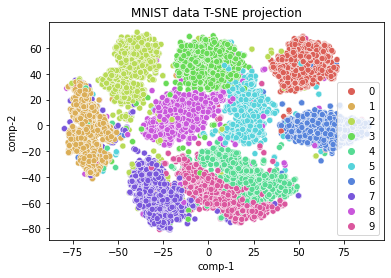

In [77]:
df = pd.DataFrame()
df["y"] = y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 10),
                data=df).set(title="MNIST data T-SNE projection")
plt.savefig('CNN_MNIST_tsne.pdf')

Compute output of each layer

In [78]:
def layer_output(model, train_loader, training_layer):
    model.eval()
    output_list = []
    with torch.no_grad():
            
        for images, labels in train_loader:
            images = images.float().to(device)
            
            outputs = model(images, training_layer)
            output_list.append([outputs[0], labels])
    
    return output_list

In [79]:
layer1_outputs = layer_output(model.to(device), loader, 'layer1')
layer2_outputs = layer_output(model.to(device), loader, 'layer2')
fc1_outputs = layer_output(model.to(device), loader, 'fc1')
fc2_outputs = layer_output(model.to(device), loader, 'fc2')

Visualize layer1

In [80]:
layer1_x = []
layer1_y = []
for item in layer1_outputs:
    x = item[0].cpu().numpy()
    y = item[1].cpu().numpy()
    layer1_x.append(x)
    layer1_y.append(y)

layer1_x = np.array(layer1_x)
layer1_y = np.array(layer1_y)

In [81]:
layer1_x = reshape(layer1_x, [layer1_x.shape[0], layer1_x.shape[1]*layer1_x.shape[2]*layer1_x.shape[3]])

In [82]:
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(layer1_x) 

/root/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.032s...
[t-SNE] Computed neighbors for 10000 samples in 3.750s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 7.220006
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.161880
[t-SNE] KL divergence after 1000 iterations: 1.826609


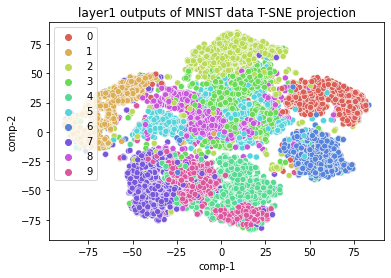

In [83]:
df = pd.DataFrame()
df["y"] = np.squeeze(layer1_y)
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 10),
                data=df).set(title="layer1 outputs of MNIST data T-SNE projection")
plt.savefig('CNN_MNIST_layer1_tsne.pdf')

Visualize layer2

In [84]:
layer2_x = []
layer2_y = []
for item in layer2_outputs:
    x = item[0].cpu().numpy()
    y = item[1].cpu().numpy()
    layer2_x.append(x)
    layer2_y.append(y)

layer2_x = np.array(layer2_x)
layer2_y = np.array(layer2_y)

In [85]:
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(layer2_x) 

/root/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.016s...
[t-SNE] Computed neighbors for 10000 samples in 3.359s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 3.942071
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.228760
[t-SNE] KL divergence after 1000 iterations: 1.785057


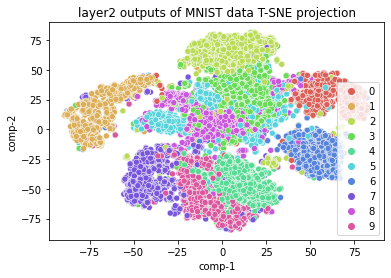

In [86]:
df = pd.DataFrame()
df["y"] = np.squeeze(layer2_y)
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 10),
                data=df).set(title="layer2 outputs of MNIST data T-SNE projection")
plt.savefig('CNN_MNIST_layer2_tsne.pdf')

Visualize fc1

In [87]:
fc1_x = []
fc1_y = []
for item in fc1_outputs:
    x = item[0].cpu().numpy()
    y = item[1].cpu().numpy()
    fc1_x.append(x)
    fc1_y.append(y)

fc1_x = np.array(fc1_x)
fc1_y = np.array(fc1_y)

tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(fc1_x) 

/root/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.003s...
[t-SNE] Computed neighbors for 10000 samples in 3.436s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.314801
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.647522
[t-SNE] KL divergence after 1000 iterations: 1.586794


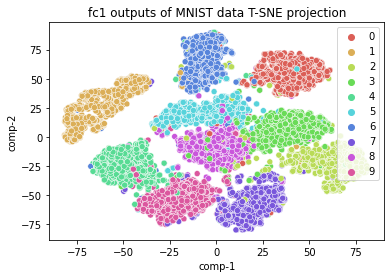

In [88]:
df = pd.DataFrame()
df["y"] = np.squeeze(fc1_y)
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 10),
                data=df).set(title="fc1 outputs of MNIST data T-SNE projection")
plt.savefig('CNN_MNIST_fc1_tsne.pdf')

Visualize fc2

In [89]:
fc2_x = []
fc2_y = []
for item in fc2_outputs:
    x = item[0].cpu().numpy()
    y = item[1].cpu().numpy()
    fc2_x.append(x)
    fc2_y.append(y)

fc2_x = np.array(fc2_x)
fc2_y = np.array(fc2_y)

tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(fc2_x) 

/root/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.014s...
[t-SNE] Computed neighbors for 10000 samples in 0.903s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.339767
[t-SNE] KL divergence after 1000 iterations: 0.537666


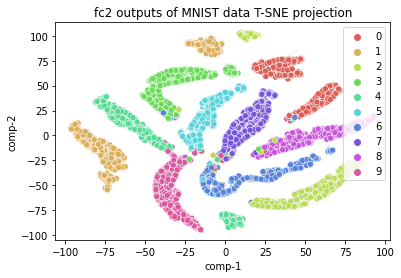

In [90]:
df = pd.DataFrame()
df["y"] = np.squeeze(fc2_y)
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 10),
                data=df).set(title="fc2 outputs of MNIST data T-SNE projection")
plt.savefig('CNN_MNIST_fc2_tsne.pdf')